Gym toolkit modified for this particular assignment

In [107]:
from IPython import display
import numpy as np
from collections import namedtuple
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10 as per assignment rules
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] 


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def use_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def hand_total(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
     
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

env = gym.make('Blackjack-v0')

In [108]:
def random_pol(nA):
   
    A = np.ones(nA, dtype = float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [109]:
def greedy_pol(Q):
    
    def policy_fn(observation):
       
        props = Q[observation]
        best_action = np.argmax(props)
        A = np.zeros((len(props)), dtype = float)
        A[best_action] = 1.
        return A
    return policy_fn

In [110]:
def Qpolicy(env, num_episodes, behavior_policy, discount_factor = 1.0):
   
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    D = defaultdict(lambda: np.zeros(env.action_space.n))
    

    Q = defaultdict(lambda: np.zeros(env.action_space.n))    # A dictionary that contains state -> action values
    target_policy = greedy_pol(Q)   
   
    for i_episode in range(num_episodes):
        observation = env.reset()
        
        episodes = []
        for i in range(100):
            props = behavior_policy(observation)
            action = np.random.choice(np.arange(len(props)), p = props)
            next_observation, reward, done, _ = env.step(action)
            episodes.append((observation, action, reward))
            if done:
                break
            observation = next_observation
        
        pairs = set([(episode[0], episode[1]) for episode in episodes])
        for (observation, action) in pairs:
            pair = (observation, action)
            
            idx = episodes.index([episode for episode in episodes if episode[0] == observation and episode[1] == action][0])
            
            V = sum([episode[2] * discount_factor ** i for episode in episodes[idx:]])
            
            w = np.product([1. / behavior_policy(episode[0])[episode[1]] for episode in episodes[idx:]])
            
            N[observation][action] += w * V
            D[observation][action] += w
            
            Q[observation][action] = N[observation][action] / D[observation][action]
        
    return Q, target_policy

In [116]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline


def plotval(V, title = "Value Function"):

    x_range = np.arange(11, max(k[0] for k in V.keys()) + 1)
    y_range = np.arange(min(k[1] for k in V.keys()), max(k[1] for k in V.keys()) + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (15, 7.5))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1, vmax = 1)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_ace, "{}".format(title))


Over 1000 games

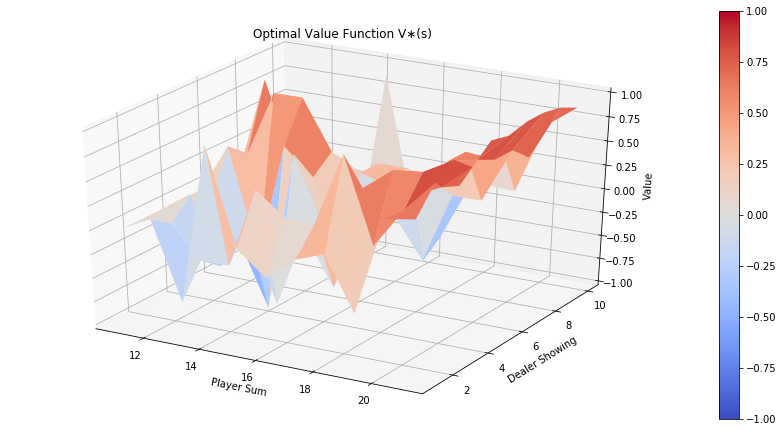

In [117]:
Policy = random_pol(env.action_space.n)
Q, policy = Qpolicy(env, num_episodes = 10000, behavior_policy = Policy)

# by picking the best action at each state
V = defaultdict(float)

for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
    
plotval(V, title = 'Optimal Value Function V∗(s)')

Over Hundred 100 games

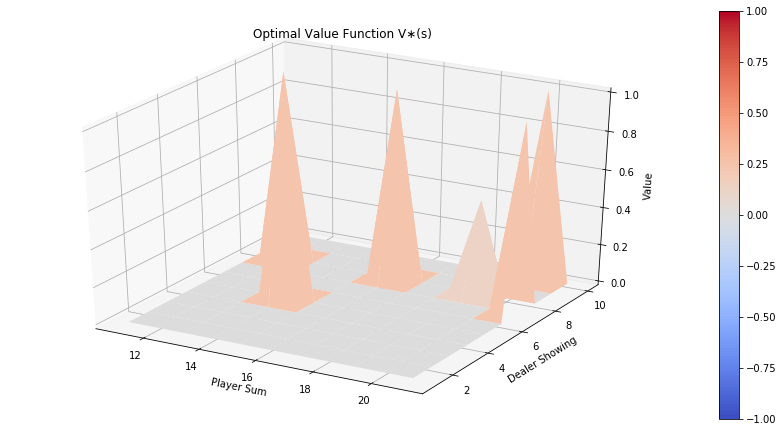

In [120]:
Q, policy = Qpolicy(env, num_episodes = 100, behavior_policy = Policy)

# by picking the best action at each state
V = defaultdict(float)

for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
    
plotval(V, title = 'Optimal Value Function V∗(s)')